In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb#scrollTo=THY-sZMiQ4UV

https://www.tensorflow.org/tutorials/generative/pix2pix

In [0]:
# this is demonstrate image translation using conditional GAN,
# https://arxiv.org/abs/1611.07004


This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 15 seconds on a single V100 GPU.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython import display

In [0]:
# Data URL

_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

In [0]:
path_to_zip = tf.keras.utils.get_file('facades.tar.gz', origin=_URL, extract=True)

Definition of the fpath of get_file

In [0]:
# img=plt.imread('/content/Screenshot from 2020-02-10 21-17-33.png')
# plt.figure(figsize=(8,12))
# plt.imshow(img)
# plt.show()

In [0]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [0]:
os.listdir('/root/.keras/datasets/')  # created from keras get_file

['facades.tar.gz', 'facades']

In [0]:
os.listdir('/root/.keras/datasets/facades')

['test', 'train', 'val']

In [0]:
PATH

'/root/.keras/datasets/facades/'

In [0]:
# Set hyperparams

BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file) 
  image = tf.io.decode_image(image)

  w = tf.shape(image)[1]    # image  = [h, w, c]

  w = w//2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [0]:
# test_image = tf.io.read_file(os.path.join('/root/.keras/datasets/facades/train', os.listdir(PATH + '/train/')[0]))

In [0]:
# test_image  # tf.io.read_file contains numpy bytes

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x01\x00\x02\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x8

In [0]:
# test_image = tf.io.decode_image(test_image)

# test_image.shape

TensorShape([256, 512, 3])

In [0]:
# test_image

<tf.Tensor: shape=(256, 512, 3), dtype=uint8, numpy=
array([[[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [  0,   0, 222],
        [  0,   0, 222],
        [  0,   0, 222]],

       [[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [  0,   0, 222],
        [  0,   0, 222],
        [  0,   0, 222]],

       [[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [  0,   0, 222],
        [  0,   0, 222],
        [  0,   0, 222]],

       ...,

       [[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [  0,   0, 222],
        [  0,   0, 222],
        [  0,   0, 222]],

       [[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [  0,   0, 222],
        [  0,   0, 222],
        [  0,   0, 222]],

       [[131, 131, 131],
        [131, 131, 131],
        [131, 131, 131],
        ...,
        [  0,   0, 22

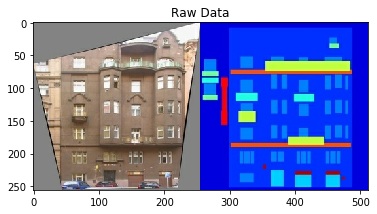

In [0]:
# the data format is concatenated [original, pixcel] image
plt.figure()
plt.title('Raw Data')
plt.imshow(test_image)
plt.show()

In [0]:
# w = tf.shape(test_image)[1]    # image  = [h, w, c]  <- 512

# w = w//2    # <- 256
# test_real_image = test_image[:, :w, :] # 256, 256, 3
# test_input_image = test_image[:, w:, :] # 256, 256, 3

Text(0.5, 1.0, 'input_image')

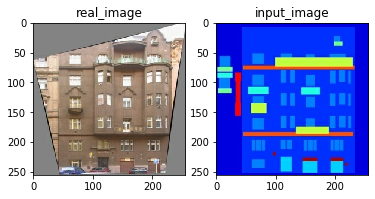

In [0]:
# plt.subplot(1,2,1)
# plt.imshow(test_real_image)
# plt.title('real_image')

# plt.subplot(1,2,2)
# plt.imshow(test_input_image)
# plt.title('input_image')

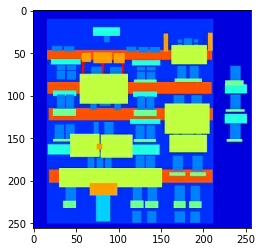

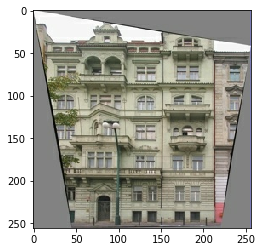

In [0]:
# function checker

inp, re = load(PATH + 'train/100.jpg')

plt.figure()
plt.imshow(inp/255.)

plt.figure()
plt.imshow(re/255.)

In [0]:
# load image file and split to input and real image

def load(image_file):
  image = tf.io.read_file(image_file) 
  image = tf.io.decode_jpeg(image)  # TF.IO.DECODE_IMAGE RETURN NOT TENSOR

  w = tf.shape(image)[1]    # image  = [h, w, c]

  w = w//2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [0]:
# resize function

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [0]:
# random crop function

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)

  cropped_image = tf.image.random_crop(stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image[0], cropped_image[1]

In [0]:
# test_stacked_image = tf.stack([inp, re], axis=0)

In [0]:
# test_stacked_image.shape

TensorShape([2, 256, 256, 3])

In [0]:
# normalize function

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) -1
  real_image = (real_image / 127.7) - 1

  return input_image, real_image

In [0]:
# create small data augmentation

@tf.function
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  
  return input_image, real_image

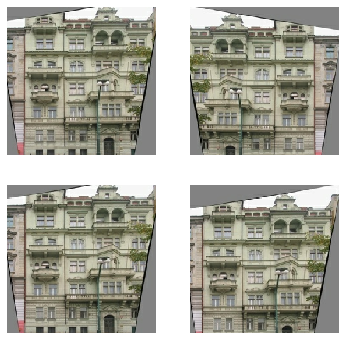

In [0]:
plt.figure(figsize=(6, 6))

for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_re/255.0)
  plt.axis('off')
plt.show()

In [0]:
# create train loader
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [0]:
# create test loader
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [0]:
t1, t2 = load_image_train(PATH + 'train/100.jpg')

In [0]:
# !!!! Tensorflow Data Input Pipeline

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')

In [0]:
for ind, i in enumerate(train_dataset):
  print(i)
  if ind == 3:
    break

tf.Tensor(b'/root/.keras/datasets/facades/train/27.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/facades/train/134.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/facades/train/22.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/facades/train/397.jpg', shape=(), dtype=string)


In [0]:
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [0]:
for ind, (t1, t2) in enumerate(train_dataset):
  print(t1.shape)
  print(t1)
  print(t2.shape)
  if ind == 0:
    break

(1, 256, 256, 3)
tf.Tensor(
[[[[-1.         -0.6313726   0.9843137 ]
   [-1.         -0.6313726   0.99215686]
   [-1.         -0.6392157   1.        ]
   ...
   [-0.78039217 -0.67058825  0.5686275 ]
   [-0.78039217 -0.67058825  0.5764706 ]
   [-0.78039217 -0.67058825  0.5686275 ]]

  [[-1.         -0.62352943  1.        ]
   [-1.         -0.6313726   1.        ]
   [-1.         -0.6392157   1.        ]
   ...
   [-0.4823529  -0.7019608   0.09803927]
   [-0.4823529  -0.7019608   0.10588241]
   [-0.4823529  -0.7019608   0.09803927]]

  [[-0.96862745 -0.6313726   0.9372549 ]
   [-0.9843137  -0.6313726   0.9607843 ]
   [-0.96862745 -0.6392157   0.99215686]
   ...
   [ 0.30196083 -0.30196077  0.02745104]
   [ 0.30196083 -0.30196077  0.02745104]
   [ 0.30196083 -0.30196077  0.02745104]]

  ...

  [[-0.99215686 -0.6313726   1.        ]
   [-0.99215686 -0.6313726   1.        ]
   [-0.9843137  -0.6313726   0.9764706 ]
   ...
   [-0.9529412  -0.654902    0.9843137 ]
   [-0.94509804 -0.64705884  

In [0]:
test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build Generator

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0.0, 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
inp.shape

TensorShape([256, 256, 3])

In [0]:
down_model = downsample(3, 4)

down_result = down_model(tf.expand_dims(inp, 0))  # when feed the down model
print(down_result.shape)

(1, 128, 128, 3)


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  
  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
up_model = upsample(3,4)

up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [0]:

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [downsample(64, 4, apply_batchnorm=False),
                downsample(128,4),
                downsample(256,4),
                downsample(512,4),
                downsample(512,4),
                downsample(512,4),
                downsample(512,4),
                downsample(512,4)]
  
  up_stack = [upsample(512, 4, apply_dropout=True), # 1024
              upsample(512, 4, apply_dropout=True), # 1024
              upsample(512, 4, apply_dropout=True), # 1024
              upsample(512, 4),                     # 1024
              upsample(256, 4),                     # 512
              upsample(128, 4),                     # 256
              upsample(64, 4)                       # 128
              ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # [bs, 256, 256, 3]

  x = inputs

  # downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])


  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

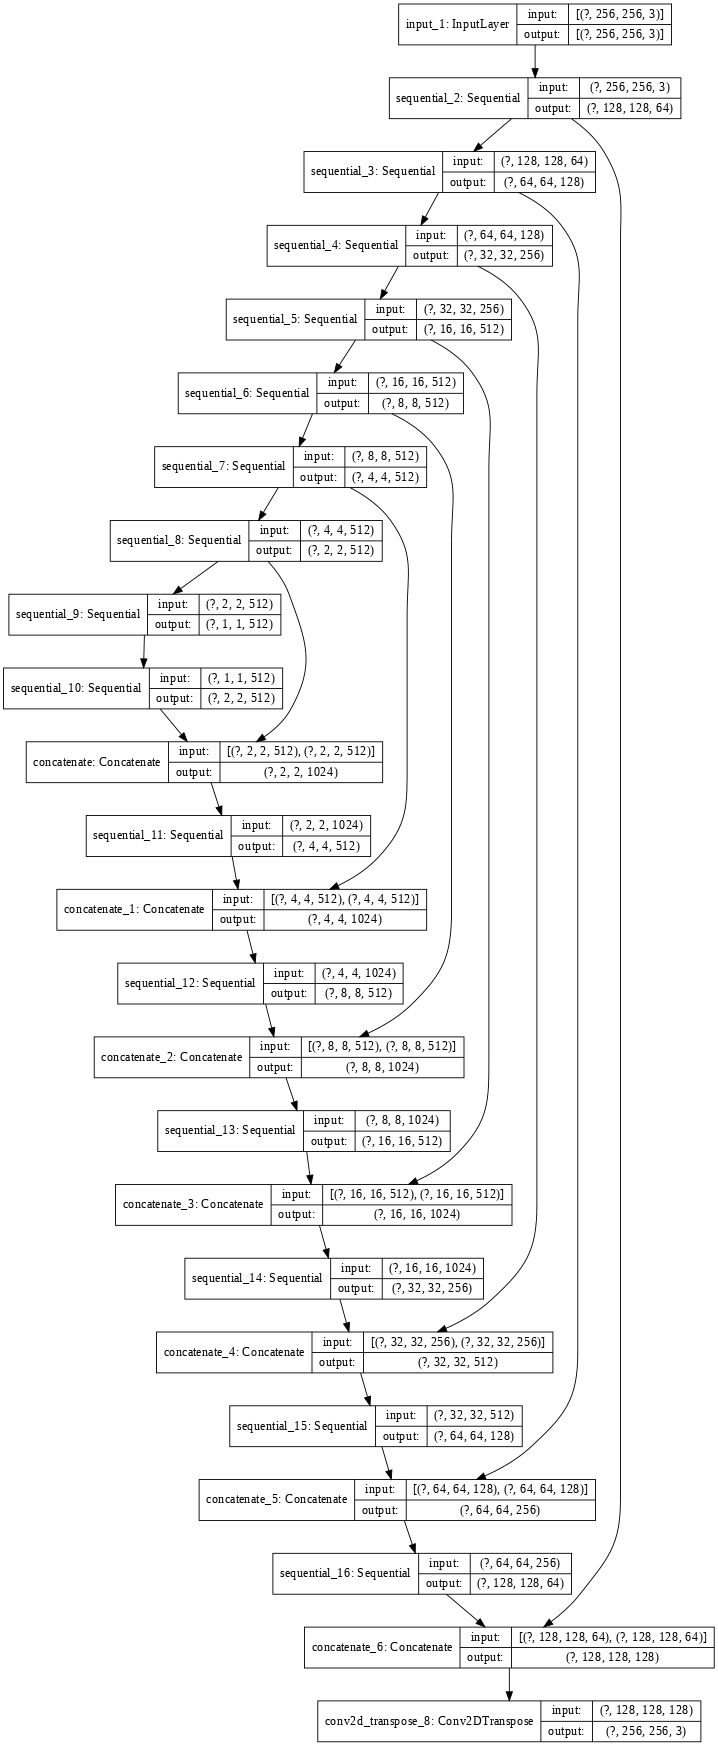

In [0]:
# The architecture of generator is modified from U-NET
# ENCODER : CONV -> BATCHNORM -> LEAKY RELU
# DECODER : CONVT -> BATHCNOR -> DROPOUT -> RELU
# SKIP CONNECTION BETWEEN ENCODER : DECODER

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

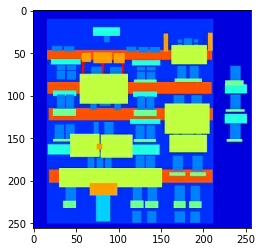

In [0]:
# putting the input image
plt.imshow(inp/255.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


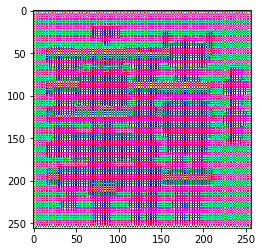

In [0]:
# Testing gen

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [0]:
inp[...].shape

TensorShape([256, 256, 3])

In [0]:
inp[tf.newaxis,...].shape

TensorShape([1, 256, 256, 3])

## Set Anatomy

In [0]:
# down_stack = [downsample(64, 4, apply_batchnorm=False),
#               downsample(128,4),
#               downsample(256,4),
#               downsample(512,4),
#               downsample(512,4),
#               downsample(512,4),
#               downsample(512,4),
#               downsample(512,4)]

# inputs = tf.keras.layers.Input(shape=[256,256,3])
# x = inputs

In [0]:
# skips = []
# for down in down_stack:
#   x = down(x)
#   skips.append(x)

In [0]:
# skips

[<tf.Tensor 'sequential_35/Identity:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'sequential_36/Identity:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'sequential_37/Identity:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'sequential_38/Identity:0' shape=(None, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'sequential_39/Identity:0' shape=(None, 8, 8, 512) dtype=float32>,
 <tf.Tensor 'sequential_40/Identity:0' shape=(None, 4, 4, 512) dtype=float32>,
 <tf.Tensor 'sequential_41/Identity:0' shape=(None, 2, 2, 512) dtype=float32>,
 <tf.Tensor 'sequential_42/Identity:0' shape=(None, 1, 1, 512) dtype=float32>]

In [0]:
# skips = reversed(skips[:-1])

In [0]:
# for i in skips:
#   print(i)

Tensor("sequential_41/Identity:0", shape=(None, 2, 2, 512), dtype=float32)
Tensor("sequential_40/Identity:0", shape=(None, 4, 4, 512), dtype=float32)
Tensor("sequential_39/Identity:0", shape=(None, 8, 8, 512), dtype=float32)
Tensor("sequential_38/Identity:0", shape=(None, 16, 16, 512), dtype=float32)
Tensor("sequential_37/Identity:0", shape=(None, 32, 32, 256), dtype=float32)
Tensor("sequential_36/Identity:0", shape=(None, 64, 64, 128), dtype=float32)
Tensor("sequential_35/Identity:0", shape=(None, 128, 128, 64), dtype=float32)


## Define generator loss

the loss function is sigmoid cross entropy for generated images and an array of ones

this also use both sigmoid & MAE https://arxiv.org/abs/1611.07004

The implementaion by using lambda is from https://arxiv.org/abs/1611.07004


In [0]:
LAMBDA = 100

In [0]:
@tf.function
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)  

  # mae
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss



![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


# Build Descriminator

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256,256,3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256,256,3], name='target_image')

  x = tf.keras.layers.Concatenate()([inp, tar]) 

  down1 = downsample(64, 4, False)(x)
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # padding (1,1)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model([inp, tar], last)

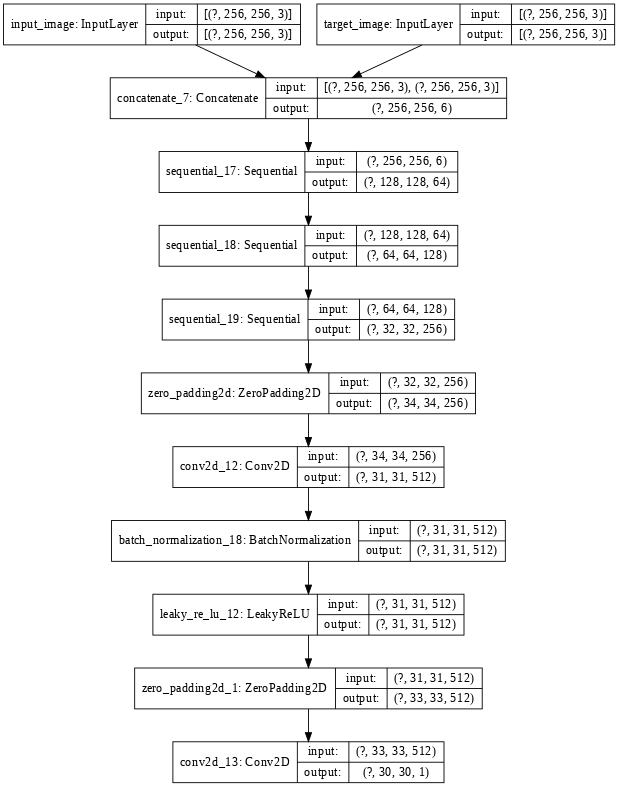

In [0]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

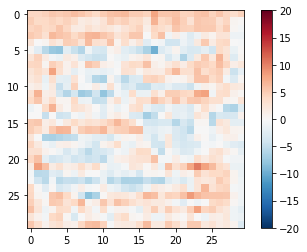

In [0]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

In [0]:
# Set discriminator loss

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_obejct(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss


In [0]:
# The training procedure


![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [0]:
check_point_dir = 'training_checkpoint'

checkpoint_prefix = os.path.join(check_point_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


# New Section

In [0]:
# This function is for drawing a plot during training

def generate_image(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['input image', 'ground truth', 'predicted image']

  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

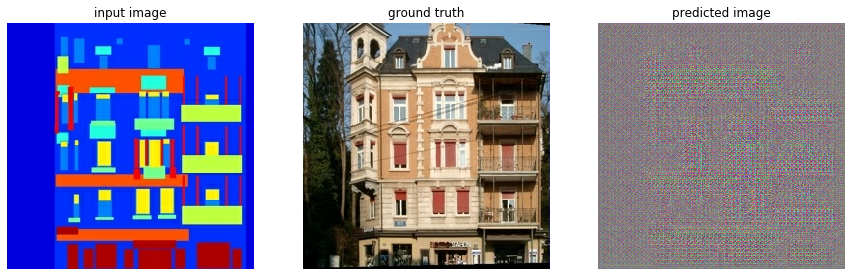

In [0]:
for example_input, example_target in test_dataset.take(1):
  generate_image(generator, example_input, example_target)

# !! Training

In [0]:
EPOCHS = 150

import datetime
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradient = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))


  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, stop=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
# @tf.function
# def train_step(input_image, target, epoch):
#   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#     gen_output = generator(input_image, training=True)

#     disc_real_output = discriminator([input_image, target], training=True)
#     disc_generated_output = discriminator([input_image, gen_output], training=True)

#     gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#     disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#   generator_gradients = gen_tape.gradient(gen_total_loss,
#                                           generator.trainable_variables)
#   discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator.trainable_variables)

#   generator_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator.trainable_variables))
#   discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator.trainable_variables))

#   with summary_writer.as_default():
#     tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
#     tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
#     tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
#     tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_image(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir {log_dir}

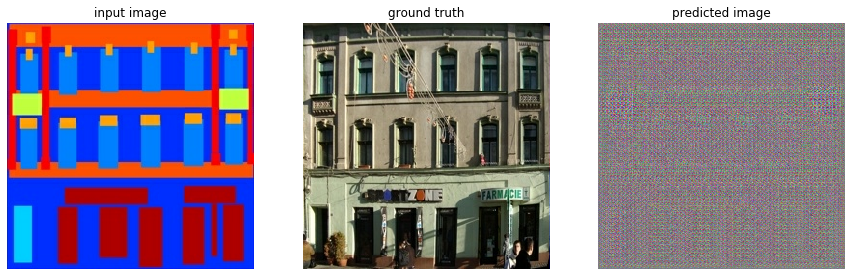

Epoch:  0
.

OperatorNotAllowedInGraphError: ignored

In [0]:
# Fit the model
fit(train_dataset, EPOCHS, test_dataset)

## From original

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss




def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)


def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

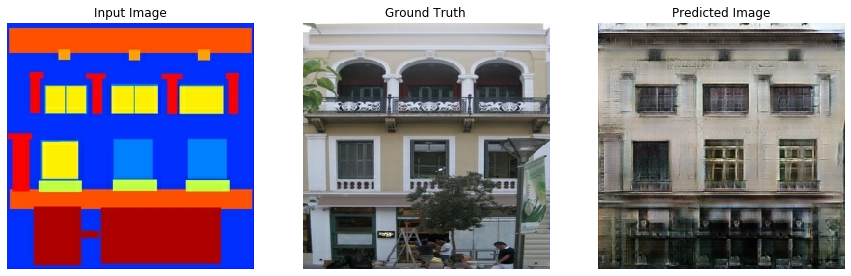

Epoch:  149
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Time taken for epoch 150 is 23.637325286865234 sec



In [0]:
fit(train_dataset, EPOCHS, test_dataset)

In [0]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

Output hidden; open in https://colab.research.google.com to view.